## Recreating LeNet CNN

In this notebook we'll recreate one of the earliest CNN's, LeNet, from scratch (for more info about LeNet see [the 1998 paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)).

### Setup

Let's start by importing the required libraries and defining some required variables

In [41]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib

batch_size = 100
num_classes = 10
learning_rate = 0.0001
num_epochs = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Downloading and Loading the Dataset

We'll now download the MNIST dataset, apply some transformations (e.g. resizing, converting to tensors, and normalizing them using previously-computed means and standard deviations).

In [42]:
# create and load the datasets for both training and validation
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True,
                                           transform = transforms.Compose([
                                                transforms.Resize((32,32)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean = (0.1307,), std = (0.3081,))
                                                ]))

val_dataset = torchvision.datasets.MNIST(root='../data', train=False, download=True, 
                                         transform=transforms.Compose([
                                                transforms.Resize((32,32)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean = (0.1325,), std = (0.3105,))
                                                ]))

In [43]:
len(train_dataset)

60000

In [ ]:
# create the dataloaders for training and for validation datasets
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

Let's try looking at a single image in the dataset.

([], [])

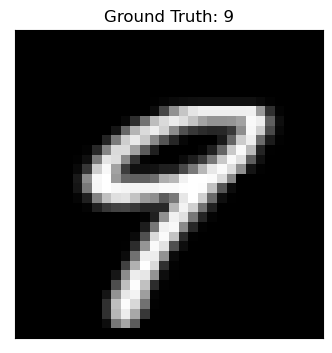

In [45]:
i = 40235
train_dataset[i] # both the image and the label; [i][0] is the image data, [i][1] is the label
plt.tight_layout()
plt.imshow(train_dataset[i][0].squeeze(), cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(train_dataset[i][1]))
plt.xticks([])
plt.yticks([])

Now, let's try looking at several images at once from the training set using the PyTorch `DataLoader`. 

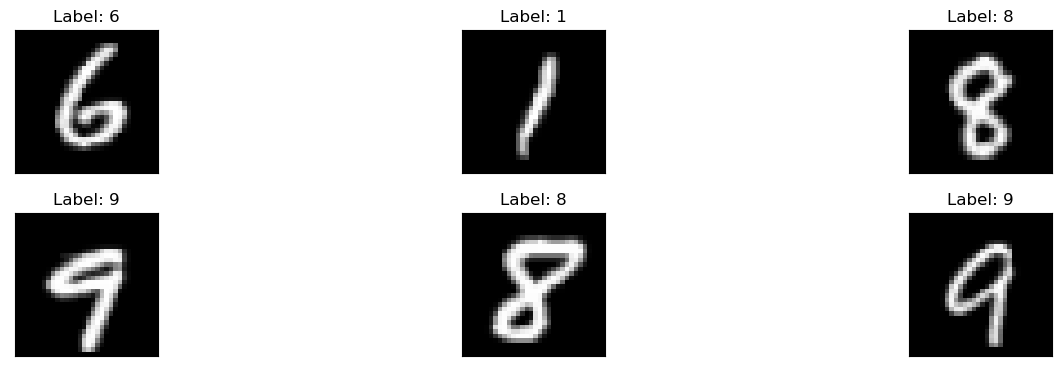

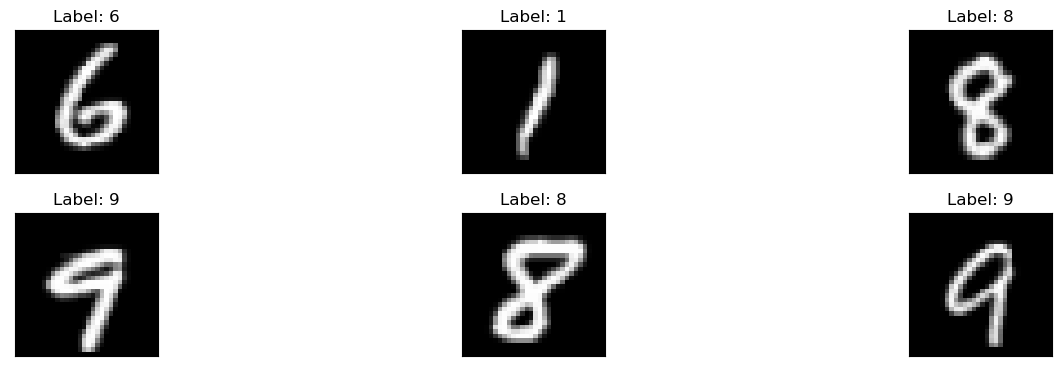

In [46]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig


### LeNet From Scratch

Next we'll define the LeNet CNN, following the original architecture. 


In [47]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

### Instantiating the Model

In [48]:
model = LeNet(num_classes).to(device)

# define loss function and optimizer
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

### Training the Model

In [49]:
n_train_batches = len(train_loader)
n_val_batches = len(val_loader)

losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):

    model.train()
    running_loss_train = 0.0

    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = loss_fun(outputs, labels)
        losses['train'].append(loss.item())
        running_loss_train += loss.item()
        	
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 200 == 0:
            print(f"    train batch {i+1:3.0f} (of {n_train_batches:3.0f}) loss: {loss.item():.4f}")
        
    running_loss_train = running_loss_train / len(train_loader)

    model.eval() # turn off the automatic differentiation 
    running_loss_val = 0.0

    for i, (images, labels) in enumerate(val_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # forward (no backward step for validation data)
        outputs = model(images)
        loss = loss_fun(outputs, labels)
        losses['val'].append(loss.item())
        running_loss_val += loss.item()
        if (i+1) % 50 == 0:
            print(f"    valid batch {i+1:3.0f} (of {n_val_batches:3.0f}) loss: {loss.item():.4f}")

    running_loss_val = running_loss_val / len(val_loader)
    print(f"Epoch {epoch+1} (of {num_epochs}): mean train loss = {running_loss_train:.4f}, mean val loss = {running_loss_val:.4f}")
    

    train batch 200 (of 600) loss: 0.6919
    train batch 400 (of 600) loss: 0.2000
    train batch 600 (of 600) loss: 0.1624
    valid batch  50 (of 100) loss: 0.2066
    valid batch 100 (of 100) loss: 0.1944
Epoch 1 (of 6): mean train loss = 0.6831, mean val loss = 0.1633
    train batch 200 (of 600) loss: 0.1922
    train batch 400 (of 600) loss: 0.1066
    train batch 600 (of 600) loss: 0.1386
    valid batch  50 (of 100) loss: 0.1039
    valid batch 100 (of 100) loss: 0.1296
Epoch 2 (of 6): mean train loss = 0.1376, mean val loss = 0.0948
    train batch 200 (of 600) loss: 0.1324
    train batch 400 (of 600) loss: 0.1035
    train batch 600 (of 600) loss: 0.0952
    valid batch  50 (of 100) loss: 0.0809
    valid batch 100 (of 100) loss: 0.0727
Epoch 3 (of 6): mean train loss = 0.0961, mean val loss = 0.0761
    train batch 200 (of 600) loss: 0.1026
    train batch 400 (of 600) loss: 0.0334
    train batch 600 (of 600) loss: 0.1300
    valid batch  50 (of 100) loss: 0.0419
    val

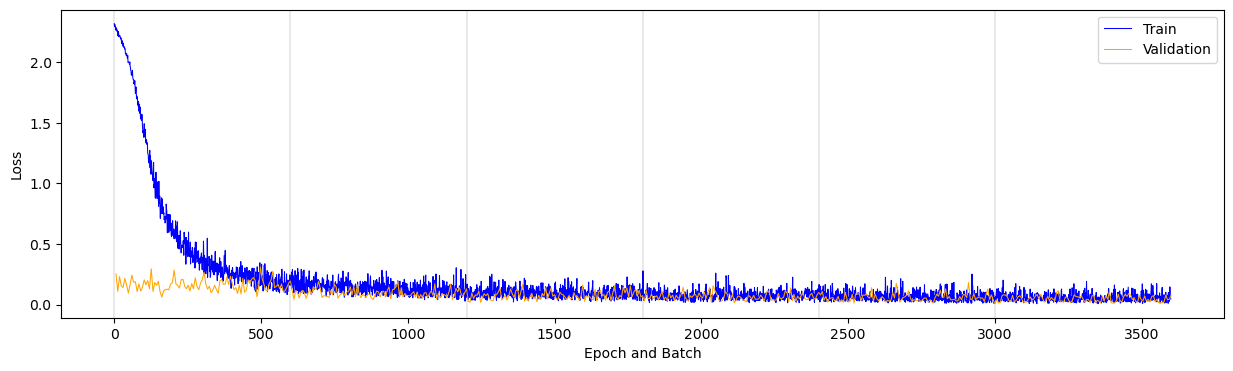

In [50]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

### Testing

In [51]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(val_dataset)} validation images): {100 * correct / total}%")
	 

Accuracy (on 10000 validation images): 98.46%


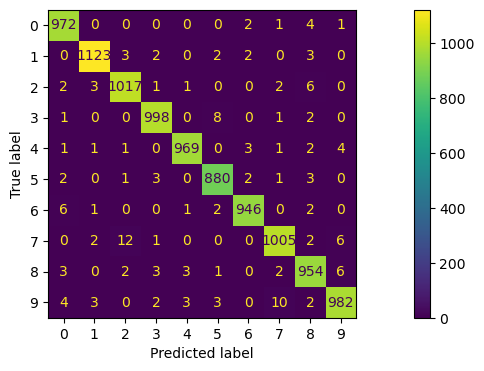

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
disp.plot()

In [53]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true, y_pred, labels=list(range(10)))

array([[[9001,   19],
        [   8,  972]],

       [[8855,   10],
        [  12, 1123]],

       [[8949,   19],
        [  15, 1017]],

       [[8978,   12],
        [  12,  998]],

       [[9010,    8],
        [  13,  969]],

       [[9092,   16],
        [  12,  880]],

       [[9033,    9],
        [  12,  946]],

       [[8954,   18],
        [  23, 1005]],

       [[9000,   26],
        [  20,  954]],

       [[8974,   17],
        [  27,  982]]])

In [54]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average=None)

array([0.98082745, 0.99117387, 0.98166023, 0.98811881, 0.99181167,
       0.98214286, 0.99057592, 0.98240469, 0.97346939, 0.98298298])

In [55]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average=None)


array([0.99183673, 0.98942731, 0.98546512, 0.98811881, 0.98676171,
       0.98654709, 0.9874739 , 0.97762646, 0.97946612, 0.97324083])

In [56]:
import torchsummary
torchsummary.summary(model, tuple(train_dataset[0][0].size()))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              ReLU-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
       BatchNorm2d-6           [-1, 16, 10, 10]              32
              ReLU-7           [-1, 16, 10, 10]               0
         MaxPool2d-8             [-1, 16, 5, 5]               0
            Linear-9                  [-1, 120]          48,120
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
Total params: 61,750
Trainable params: 

In [58]:
(5*5) * 6 + 6 

156

In [60]:
train_dataset[0][0].size()

torch.Size([1, 32, 32])

In [61]:
16*5*5

400

In [63]:
400*120 + 120

48120